# This notebook documents and contains code for training and saving a neural network on the engineered data

first, lets import the data and split it into a test and training set. L

In [ ]:
!pip install pandas 
!pip install numpy
!pip install scikit-learn
!pip install torch

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv('data/post_FE.csv')
data = df.to_numpy()
X = data[:,:-1]
y = data[:,-1]



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
print(X_train.shape, X_test.shape)

(242, 18) (61, 18)


Now, lets define the model. Since we arent dealing with time series, images or any other "special" type of data, we will just create a neural net without any hocus pocus first, just a bunch of dense layers and activation functions

First we define the hyperparameters

In [15]:
EPOCHS = 400 # Have tried epochs ranging from 10-1000
BATCH_SIZE = 64 # Have tried 64, 32, 16, 4
LEARNING_RATE = 0.001
INPUT_FEATURES = X.shape[1]
OUTPUT_CLASSES = 2

Now, we create the dataset (convert into iterable tensors for pytorch to use)

In [16]:
import torch

class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y=None):
        super(Dataset, self).__init__()
        self.X = X
        self.y = y
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
        
    
    def __len__(self):
        return len(self.X)

# Create datasets
train_data = Dataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_data = Dataset(torch.Tensor(X_test), torch.Tensor(y_test))

# Create dataloaders for our datasets
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=X_test.shape[0])

X_test.shape[0], X_train.shape[0]


(61, 242)

Now its time to define the first version of out model

In [17]:
from torch import nn

class Model1(nn.Module):
    def __init__(self, inputs, outputs):
        super(Model1, self).__init__()
        self.inputs = inputs
        self.outputs = outputs
        
        self.input = nn.Linear(inputs, 32)
        self.seq = nn.Sequential(
            nn.Linear(32, 32, bias=False), # the dataset already contains bias
            nn.ReLU(),
            nn.Linear(32, 32, bias=False),
            nn.ReLU(),
            nn.Linear(32, 32, bias=False),
        )
        self.out = nn.Linear(32, 1)
    
    def forward(self, x):
        x = self.input(x)
        x = self.seq(x)
        x = self.out(x)
        return x


Now we have our first model version created! Lets create a function for training the model that we can reuse to test and compare different models!

In [18]:
def accuracy(predictions, labels):
    correct = (torch.round(torch.sigmoid(predictions)) == labels).sum().float()
    return correct/labels.shape[0]


def train_and_evaluate_model(model, loss_fn, optimizer, epochs, train_loader, test_loader, device, supress_output=False):

    progress_dict = {
        'train_acc' : [],
        'loss' : [],
        'test_preds' : [],
        'test_acc': []
    }
    for epoch in range(1, epochs):
        epoch_train_acc = 0
        epoch_test_acc = 0
        epoch_loss = 0

        
        # train the model
        model.train()
        for X, y in train_loader:

            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)

            loss = loss_fn(y_pred, y.unsqueeze(1))
            acc = accuracy(y_pred, y.unsqueeze(1))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_train_acc += acc.item()

        progress_dict['train_acc'].append(epoch_train_acc/len(train_loader))
        progress_dict['loss'].append(epoch_loss/len(train_loader))


        # evaluate the model on the training data for each epoch
        model.eval()
        with torch.no_grad():
            for X, y in test_loader: # Only one single batch!
                X = X.to(device)
                test_pred = model(X)
                progress_dict['test_preds'].append(torch.round(torch.sigmoid(test_pred)).numpy()) # append complete prediction list
                progress_dict['test_acc'].append(accuracy(test_pred, y.unsqueeze(1)))
                # TODO: Calculate confusion matric and accuracy and append instead

        if not supress_output and epoch % 20 == 0:
            print('Epoch', epoch, ':test accuracy', progress_dict['test_acc'][epoch-1].item(), 'loss', progress_dict['loss'][epoch-1])
    
    return progress_dict
    


In [19]:
# Select which device to perform training on

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:', device)

device: cpu


In [20]:
import numpy as np

model1 = Model1(inputs=INPUT_FEATURES, outputs=OUTPUT_CLASSES)
model1.to(device)
print(model1)
loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=LEARNING_RATE)

stats1 = train_and_evaluate_model(model=model1, loss_fn=loss, optimizer=optimizer, epochs=EPOCHS, 
                        train_loader=train_loader, test_loader=test_loader, device=device)

test_accuracies = stats1['test_acc']
best_epoch = np.argmax(test_accuracies)
print('best epoch test performance at epoch', best_epoch, 'with accuracy', test_accuracies[best_epoch])

Model1(
  (input): Linear(in_features=18, out_features=32, bias=True)
  (seq): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=False)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=False)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=False)
  )
  (out): Linear(in_features=32, out_features=1, bias=True)
)
Epoch 20 :test accuracy 0.8196721076965332 loss 0.37350790947675705
Epoch 40 :test accuracy 0.7868852615356445 loss 0.3291107639670372
Epoch 60 :test accuracy 0.8032786846160889 loss 0.29861679673194885
Epoch 80 :test accuracy 0.8196721076965332 loss 0.25840288773179054
Epoch 100 :test accuracy 0.8524590134620667 loss 0.20775703340768814
Epoch 120 :test accuracy 0.8852459192276001 loss 0.16269992664456367
Epoch 140 :test accuracy 0.8852459192276001 loss 0.12620466202497482
Epoch 160 :test accuracy 0.8852459192276001 loss 0.1007061917334795
Epoch 180 :test accuracy 0.8852459192276001 loss 0.07492768298834562
Epoch 200 :tes

This model works pretty well, although a cross-validation is needed to get a fair comparison to our SVM from step 3. Now, I want to try another model

In [21]:
# Test another model:
from torch import nn

class Model2(nn.Module):
    def __init__(self, inputs, outputs):
        super(Model2, self).__init__()
        self.inputs = inputs
        self.outputs = outputs
        
        self.input = nn.Linear(inputs, 128)
        self.seq = nn.Sequential(
            nn.Linear(128, 128, bias=False), # the dataset already contains bias
            nn.Tanh(),
            nn.Linear(128, 128, bias=False),
            nn.Tanh(),
            nn.Linear(128, 128, bias=False), # the dataset already contains bias
            nn.Tanh(),
            nn.Linear(128, 128, bias=False), # the dataset already contains bias
            nn.Tanh(),
            nn.Linear(128, 8, bias=False), # the dataset already contains bias
        )
        self.out = nn.Linear(8, 1)
    
    def forward(self, x):
        x = self.input(x)
        x = self.seq(x)
        x = self.out(x)
        return x


model2 = Model2(inputs=INPUT_FEATURES, outputs=OUTPUT_CLASSES)
model2.to(device)
print(model2)
loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=LEARNING_RATE)

stats2 = train_and_evaluate_model(model=model2, loss_fn=loss, optimizer=optimizer, epochs=EPOCHS, 
                        train_loader=train_loader, test_loader=test_loader, device=device)

test_accuracies = stats2['test_acc']
best_epoch = np.argmax(test_accuracies)
print('best epoch test performance at epoch', best_epoch, 'with accuracy', test_accuracies[best_epoch])

Model2(
  (input): Linear(in_features=18, out_features=128, bias=True)
  (seq): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=False)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=False)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=False)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=128, bias=False)
    (7): Tanh()
    (8): Linear(in_features=128, out_features=8, bias=False)
  )
  (out): Linear(in_features=8, out_features=1, bias=True)
)
Epoch 20 :test accuracy 0.8032786846160889 loss 0.34065549075603485
Epoch 40 :test accuracy 0.8032786846160889 loss 0.3278341740369797
Epoch 60 :test accuracy 0.8032786846160889 loss 0.25719664990901947
Epoch 80 :test accuracy 0.7540983557701111 loss 0.23718272149562836
Epoch 100 :test accuracy 0.8196721076965332 loss 0.15226822905242443
Epoch 120 :test accuracy 0.8196721076965332 loss 0.160201046615839
Epoch 140 :test accuracy 0.8196721076965332 loss 0.100381519

Now that we have created, trained and tested two models, lets compare the two with some plots!

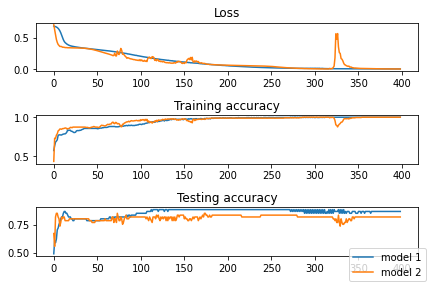

In [22]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(3)

axs[0].plot(stats1['loss'], label='model 1')
axs[0].plot(stats2['loss'], label='model 2')
axs[0].set_title('Loss')
axs[1].plot(stats1['train_acc'])
axs[1].plot(stats2['train_acc'])
axs[1].set_title('Training accuracy')

axs[2].plot(stats1['test_acc'])
axs[2].plot(stats2['test_acc'])
axs[2].set_title('Testing accuracy')
fig.legend(loc='lower right')

fig.tight_layout()

fig.savefig('images/NN_comp.png', dpi=300)


Both models seem to perform rather well! Model 1 performs slightly better in stability during training, so let's cross-validate that model

In [23]:
from sklearn.model_selection import KFold
import numpy as np
# Perform manual KFold cross-validation
kf = KFold(n_splits = 10) # Same amount of splits as for Logistic Regression
kf.get_n_splits(X)

test_accuracies = stats1['test_acc']
EPOCHS = np.argmax(test_accuracies) # best epoch seen to testing performance
print(EPOCHS)
# We are interested in saving the test accuracies
test_accuracies = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(len(train_index), len(test_index))
    # Now, for each set of data, we train the neural network 2 for the optimal amount of epochs

    # Create datasets
    train_data = Dataset(torch.Tensor(X_train), torch.Tensor(y_train))
    test_data = Dataset(torch.Tensor(X_test), torch.Tensor(y_test))

    # Create dataloaders for our datasets
    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE)
    test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=X_test.shape[0])
    # Given that performance was identical, we choose the simple network for speed
    cross_val_model = Model1(inputs=INPUT_FEATURES, outputs=OUTPUT_CLASSES)
    loss = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(cross_val_model.parameters(), lr=LEARNING_RATE)

    stats = train_and_evaluate_model(model=cross_val_model, loss_fn=loss, optimizer=optimizer, epochs=EPOCHS, 
                        train_loader=train_loader, test_loader=test_loader, device=device, supress_output=True)
    
    test_acc = stats['test_acc'][-1] # the last one
    print('fold test accuracy:', test_acc)
    test_accuracies.append(test_acc)

print('average cross-validated test accuracy:', np.mean(test_accuracies))


112
272 31
fold test accuracy: tensor(0.7742)
272 31
fold test accuracy: tensor(0.8065)
272 31
fold test accuracy: tensor(0.8065)
273 30
fold test accuracy: tensor(0.8000)
273 30
fold test accuracy: tensor(0.7333)
273 30
fold test accuracy: tensor(0.8333)
273 30
fold test accuracy: tensor(0.8333)
273 30
fold test accuracy: tensor(0.7000)
273 30
fold test accuracy: tensor(0.9333)
273 30
fold test accuracy: tensor(0.8000)
average cross-validated test accuracy: 0.80204296


After trying many different model architectures, I concluded that a neural network did not give a boost in performance over more traditional models like the support vector machines. This could be due to the smaller dataset of around 300 records- a deep neural net would likely need more data to work well. Nonetheless, lets save the model if we are to use it later on/deploy it in a real setting

In [24]:

# Create datasets
train_data = Dataset(torch.Tensor(X), torch.Tensor(y))
test_data = Dataset(torch.Tensor(X), torch.Tensor(y))

# Create dataloaders for our datasets
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=X_test.shape[0])
# Given that performance was identical, we choose the simple network for speed
model = Model2(inputs=INPUT_FEATURES, outputs=OUTPUT_CLASSES)
loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_and_evaluate_model(model=model, loss_fn=loss, optimizer=optimizer, epochs=EPOCHS, 
                    train_loader=train_loader, test_loader=test_loader, device=device, supress_output=False)

torch.save(model, 'model/final_NN_model.pt')


Epoch 20 :test accuracy 0.800000011920929 loss 0.34741784930229186
Epoch 40 :test accuracy 0.8666666746139526 loss 0.34045096635818484
Epoch 60 :test accuracy 0.800000011920929 loss 0.2968127906322479
Epoch 80 :test accuracy 0.800000011920929 loss 0.2729609847068787
Epoch 100 :test accuracy 0.8333333134651184 loss 0.2243106707930565
